In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install bert-for-tf2
!pip install sentencepiece

In [ ]:
try:
    %tensorflow_version 2.x
except Exception:
    pass
import tensorflow as tf

import tensorflow_hub as hub

from tensorflow.keras import layers
import bert

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
import pandas as pd
import numpy as np
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import os
import sys
import pickle
import itertools
import gensim
from sklearn.model_selection import train_test_split
from numpy import zeros
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from gensim.models import Word2Vec

In [ ]:
cd '/content/drive/My Drive/Dataset'

/content/drive/My Drive/Dataset


In [ ]:
# Importing dataset
reviews_df = pd.read_csv('Hotel_Review.csv')
print(reviews_df.dtypes)

Hotel_Address                                  object
Additional_Number_of_Scoring                    int64
Review_Date                                    object
Average_Score                                 float64
Hotel_Name                                     object
Reviewer_Nationality                           object
Negative_Review                                object
Review_Total_Negative_Word_Counts               int64
Total_Number_of_Reviews                         int64
Positive_Review                                object
Review_Total_Positive_Word_Counts               int64
Total_Number_of_Reviews_Reviewer_Has_Given      int64
Reviewer_Score                                float64
Tags                                           object
days_since_review                              object
lat                                           float64
lng                                           float64
dtype: object


In [ ]:
print(reviews_df.columns.values)

['Hotel_Address' 'Additional_Number_of_Scoring' 'Review_Date'
 'Average_Score' 'Hotel_Name' 'Reviewer_Nationality' 'Negative_Review'
 'Review_Total_Negative_Word_Counts' 'Total_Number_of_Reviews'
 'Positive_Review' 'Review_Total_Positive_Word_Counts'
 'Total_Number_of_Reviews_Reviewer_Has_Given' 'Reviewer_Score' 'Tags'
 'days_since_review' 'lat' 'lng']


In [ ]:
df=reviews_df.drop(['Hotel_Address', 'Additional_Number_of_Scoring', 'Review_Date',
 'Average_Score', 'Hotel_Name', 'Reviewer_Nationality',
 'Review_Total_Negative_Word_Counts', 'Total_Number_of_Reviews',
  'Review_Total_Positive_Word_Counts',
 'Total_Number_of_Reviews_Reviewer_Has_Given', 'Reviewer_Score', 'Tags',
 'days_since_review', 'lat', 'lng'], axis=1)

In [ ]:
def clean(text):
    '''
    '''
    text = text.lower()
    text = text.replace("ain't", "am not")
    text = text.replace("aren't", "are not")
    text = text.replace("can't", "cannot")
    text = text.replace("can't've", "cannot have")
    text = text.replace("'cause", "because")
    text = text.replace("could've", "could have")
    text = text.replace("couldn't", "could not")
    text = text.replace("couldn't've", "could not have")
    text = text.replace("should've", "should have")
    text = text.replace("should't", "should not")
    text = text.replace("should't've", "should not have")
    text = text.replace("would've", "would have")
    text = text.replace("would't", "would not")
    text = text.replace("would't've", "would not have")
    text = text.replace("didn't", "did not")
    text = text.replace("doesn't", "does not")
    text = text.replace("don't", "do not")
    text = text.replace("hadn't", "had not")
    text = text.replace("hadn't've", "had not have")
    text = text.replace("hasn't", "has not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd", "he would")
    text = text.replace("haven't", "have not")
    text = text.replace("he'd've", "he would have")
    text = text.replace("'s", "")
    text = text.replace("'t", "")
    text = text.replace("'ve", "")
    text = text.replace(".", " . ")
    text = text.replace("!", " ! ")
    text = text.replace("?", " ? ")
    text = text.replace(";", " ; ")
    text = text.replace(":", " : ")
    text = text.replace(",", " , ")
    text = text.replace("´", "")
    text = text.replace("‘", "")
    text = text.replace("’", "")
    text = text.replace("“", "")
    text = text.replace("”", "")
    text = text.replace("\'", "")
    text = text.replace("\"", "")
    text = text.replace("-", "")
    text = text.replace("–", "")
    text = text.replace("—", "")
    text = text.replace("[", "")
    text = text.replace("]","")
    text = text.replace("{","")
    text = text.replace("}", "")
    text = text.replace("/", "")
    text = text.replace("|", "")
    text = text.replace("(", "")
    text = text.replace(")", "")
    text = text.replace("$", "")
    text = text.replace("+", "")
    text = text.replace("*", "")
    text = text.replace("%", "")
    text = text.replace("#", "")
    text = text.replace("\n", " \n ")
    text = text.replace("\n", "")
    text = text.replace("_", " _ ")
    text = text.replace("_", "")
    text = ''.join([i for i in text if not i.isdigit()])

    return text

positive_reviews = reviews_df['Positive_Review'].values
negative_reviews = reviews_df['Negative_Review'].values

cleaned_positive_reviews = [clean(r) for r in positive_reviews]
cleaned_negative_reviews = [clean(r) for r in negative_reviews]

reviews_df['Positive_Review'] = cleaned_positive_reviews
reviews_df['Negative_Review'] = cleaned_negative_reviews

In [ ]:
# Shuffling data
reviews_df = reviews_df.sample(frac=1).reset_index(drop=True)

# Extracting all text
positive_reviews = reviews_df['Positive_Review'].values
negative_reviews = reviews_df['Negative_Review'].values
reviews_text = []

for p,n in zip(positive_reviews, negative_reviews) :
    if p in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        reviews_text.append(n)
    elif n in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        reviews_text.append(p)
    else :
        reviews_text.append(n)
        reviews_text.append(p)

In [ ]:
# Preprocessing training data
training_df = reviews_df.loc[:10000]
positive_reviews_filtered = training_df['Positive_Review'].values
negative_reviews_filtered = training_df['Negative_Review'].values
training_reviews = []
labels = []

for idx,(p,n) in enumerate(zip(positive_reviews_filtered, negative_reviews_filtered)) :
    if p in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        training_reviews.append(n)
        labels.append(0)
    elif n in ['na', 'nothing', 'none', 'n a', 'no', 'no positive', 'no negative'] :
        training_reviews.append(p)
        labels.append(1)
    else :
        training_reviews.append(n)
        labels.append(0)
        training_reviews.append(p)
        labels.append(1)

# Creating datasets
dict1 ={
    'reviews' : training_reviews,
    'labels' : labels
}
sentiment_df = pd.DataFrame.from_dict(dict1)


dict2 ={
    'reviews_text' : reviews_text
}
reviews_text_df = pd.DataFrame.from_dict(dict2)

In [ ]:
print(sentiment_df[:10])
print(reviews_text_df[:10])

                                             reviews  labels
0   the view from our room was brilliant and loca...       1
1                        parking only for small cars       0
2                      breakfast super good location       1
3   the hotel is located quite a bit from the cen...       0
4   the room was large the furniture nice the bat...       1
5   very noisy area with to many cars and scooter...       0
6                           location close to louvre       1
7   asked for upgrade with a good view as it was ...       0
8                         great bed and lovely staff       1
9   gym sauna small swimming pool conveniently lo...       1
                                        reviews_text
0   the view from our room was brilliant and loca...
1                        parking only for small cars
2                      breakfast super good location
3   the hotel is located quite a bit from the cen...
4   the room was large the furniture nice the bat...
5   very no

In [ ]:
def preprocess_text(sen):
    # Removing html tags
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [ ]:
import re
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

In [ ]:
reviews = []
sentences = list(sentiment_df['reviews'])
for sen in sentences:
    reviews.append(preprocess_text(sen))

In [ ]:
print(sentiment_df.columns.values)

['reviews' 'labels']


In [ ]:
sentiment_df.labels.unique()

array([1, 0])

In [ ]:
print(reviews[20])

 small room and required to climb stairs from th floor to th top floor 


In [ ]:
y = sentiment_df['labels']

In [ ]:
BertTokenizer = bert.bert_tokenization.FullTokenizer
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/1",
                            trainable=False)
vocabulary_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
to_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = BertTokenizer(vocabulary_file, to_lower_case)

In [ ]:
tokenizer.convert_tokens_to_ids(tokenizer.tokenize(reviews[10]))

[9543, 10458, 5723, 11848, 2412]

In [ ]:
def tokenize_reviews(reviews):
    return tokenizer.convert_tokens_to_ids(tokenizer.tokenize(reviews))

In [ ]:
tokenized_reviews = [tokenize_reviews(review) for review in reviews]

In [ ]:
print(tokenized_reviews[10])

[9543, 10458, 5723, 11848, 2412]


In [ ]:
reviews_with_len = [[review, y[i], len(labels)]
                 for i, review in enumerate(tokenized_reviews)]

In [ ]:
import random
random.shuffle(reviews_with_len)

In [ ]:
print(reviews_with_len[:2])

[[[3295, 2489, 4157, 5572, 2300, 1998, 2070, 17387, 2326, 2200, 2092, 4114, 6055, 2282], 1, 16836], [[2498], 0, 16836]]


In [ ]:
reviews_with_len.sort(key=lambda x: x[2])

In [ ]:
sorted_reviews_labels = [(review_lab[0], review_lab[1]) for review_lab in reviews_with_len]

In [ ]:
processed_dataset = tf.data.Dataset.from_generator(lambda: sorted_reviews_labels, output_types=(tf.int32, tf.int32))

In [ ]:
BATCH_SIZE = 32
batched_dataset = processed_dataset.padded_batch(BATCH_SIZE, padded_shapes=((None, ), ()))

In [ ]:
next(iter(batched_dataset))

(<tf.Tensor: shape=(32, 46), dtype=int32, numpy=
 array([[3295, 2489, 4157, ...,    0,    0,    0],
        [2498,    0,    0, ...,    0,    0,    0],
        [1996, 4734, 2071, ...,    0,    0,    0],
        ...,
        [3295, 6350, 3095, ...,    0,    0,    0],
        [2256, 2282, 2001, ...,    0,    0,    0],
        [6581, 3295, 2200, ...,    0,    0,    0]], dtype=int32)>,
 <tf.Tensor: shape=(32,), dtype=int32, numpy=
 array([1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
        1, 1, 1, 1, 0, 1, 0, 1, 0, 1], dtype=int32)>)

In [ ]:
import math
TOTAL_BATCHES = math.ceil(len(sorted_reviews_labels) / BATCH_SIZE)
TEST_BATCHES = TOTAL_BATCHES // 10
batched_dataset.shuffle(TOTAL_BATCHES)
test_data = batched_dataset.take(TEST_BATCHES)
train_data = batched_dataset.skip(TEST_BATCHES)

In [ ]:
import tensorflow as tf
import keras

In [ ]:

class TEXT_MODEL(tf.keras.Model):

    def __init__(self,
                 vocabulary_size,
                 embedding_dimensions=128,
                 cnn_filters=50,
                 dnn_units=512,
                 model_output_classes=2,
                 dropout_rate=0.1,
                 training=False,
                 name="text_model"):
        super(TEXT_MODEL, self).__init__(name=name)

        self.embedding = layers.Embedding(vocabulary_size,
                                          embedding_dimensions)
        #self.rnn_layer = layers.Bidirectional(self.rnn_layer.layers.LSTM(32)),
        self.cnn_layer1 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=2,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer2 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=3,
                                        padding="valid",
                                        activation="relu")
        self.cnn_layer3 = layers.Conv1D(filters=cnn_filters,
                                        kernel_size=4,
                                        padding="valid",
                                        activation="relu")
        self.pool = layers.GlobalMaxPool1D()

        self.dense_1 = layers.Dense(units=dnn_units, activation="relu")
        self.dropout = layers.Dropout(rate=dropout_rate)
        if model_output_classes == 2:
            self.last_dense = layers.Dense(units=1,
                                           activation="sigmoid")
        else:
            self.last_dense = layers.Dense(units=model_output_classes,
                                           activation="softmax")

    def call(self, inputs, training):
        l = self.embedding(inputs)
        l_1 = self.cnn_layer1(l)
        l_1 = self.pool(l_1)
        l_2 = self.cnn_layer2(l)
        l_2 = self.pool(l_2)
        l_3 = self.cnn_layer3(l)
        l_3 = self.pool(l_3)
        concatenated = tf.concat([l_1, l_2, l_3,], axis=-1) # (batch_size, 4 * rmdl_filters)
        concatenated = self.dense_1(concatenated)
        concatenated = self.dropout(concatenated, training)
        model_output = self.last_dense(concatenated)

        return model_output

In [ ]:
VOCAB_LENGTH = len(tokenizer.vocab)
EMB_DIM = 200
CNN_FILTERS = 100
DNN_UNITS = 256
OUTPUT_CLASSES = 2

DROPOUT_RATE = 0.2

In [ ]:
text_model = TEXT_MODEL(vocabulary_size=VOCAB_LENGTH,
                        embedding_dimensions=EMB_DIM,
                        cnn_filters=CNN_FILTERS,
                        dnn_units=DNN_UNITS,
                        model_output_classes=OUTPUT_CLASSES,
                        dropout_rate=DROPOUT_RATE)

In [ ]:
if OUTPUT_CLASSES == 2:
    text_model.compile(loss="binary_crossentropy",
                       optimizer="adam",
                       metrics=["accuracy"])
else:
    text_model.compile(loss="sparse_categorical_crossentropy",
                       optimizer="adam",
                       metrics=["sparse_categorical_accuracy"])

In [ ]:
# Assuming you have already defined your model architecture and compiled it

# Define the number of epochs
NB_EPOCHS = 5

# Train the model
history = text_model.fit(train_data, epochs=5)


Epoch 1/5
475/475 [==============================] - 105s 219ms/step - loss: 0.0549 - accuracy: 0.9822
Epoch 2/5
475/475 [==============================] - 103s 216ms/step - loss: 0.0487 - accuracy: 0.9835
Epoch 3/5
475/475 [==============================] - 103s 217ms/step - loss: 0.0405 - accuracy: 0.9862
Epoch 4/5
475/475 [==============================] - 100s 209ms/step - loss: 0.0390 - accuracy: 0.9866
Epoch 5/5
475/475 [==============================] - 99s 207ms/step - loss: 0.0366 - accuracy: 0.9877


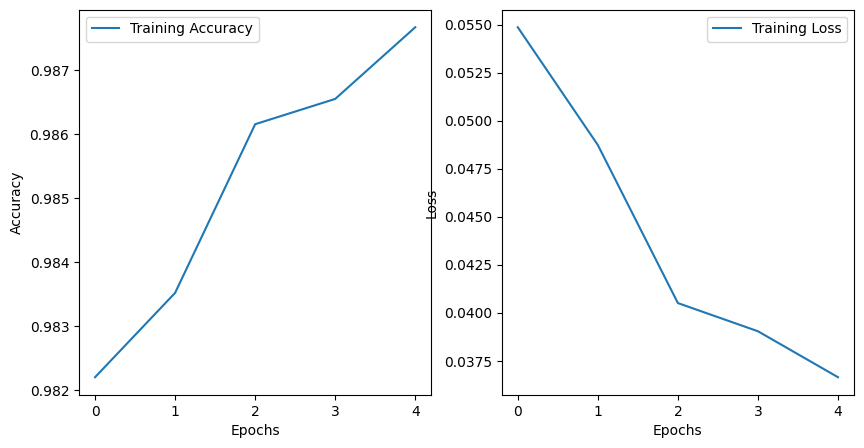

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel("Epochs")
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel("Epochs")
plt.ylabel('Loss')
plt.legend()

plt.show()

In [ ]:
y_pred = tf.nn.softmax(text_model.predict(test_data))

52/52 [==============================] - 2s 41ms/step


In [ ]:
y_pred_argmax = tf.math.argmax(y_pred, axis=1)

In [ ]:
y_true = tf.Variable([], dtype=tf.int32)

for reviews, labels in test_data.take(-1):
    y_true = tf.concat([y_true, labels], 0)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      0.45      0.62      1664
           1       0.00      0.00      0.00         0

    accuracy                           0.45      1664
   macro avg       0.50      0.23      0.31      1664
weighted avg       1.00      0.45      0.62      1664



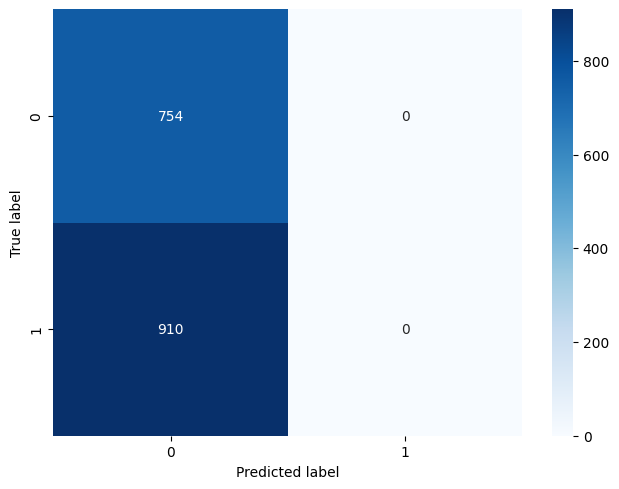

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report

def visualize_confusion_matrix(y_pred_argmax, y_true):
    """

    :param y_pred_arg: This is an array with values that are 0 or 1
    :param y_true: This is an array with values that are 0 or 1
    :return:
    """

    cm = tf.math.confusion_matrix(y_true, y_pred_argmax).numpy()
    con_mat_df = pd.DataFrame(cm)

    print(classification_report(y_pred_argmax, y_true))

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

#print(classification_report(test_labels, baseline_predicted))
visualize_confusion_matrix(y_pred_argmax, y_true)

In [ ]:
loss, accuracy = text_model.evaluate(test_data)
print('Test Loss: {}'.format(loss))
print('Test Accuracy: {}'.format(accuracy))

52/52 [==============================] - 3s 49ms/step - loss: 0.5089 - accuracy: 0.9075
Test Loss: 0.5089177489280701
Test Accuracy: 0.9074519276618958


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.45      1.00      0.62       754
           1       0.00      0.00      0.00       910

    accuracy                           0.45      1664
   macro avg       0.23      0.50      0.31      1664
weighted avg       0.21      0.45      0.28      1664

Matthews Correlation Coefficient: 0.0


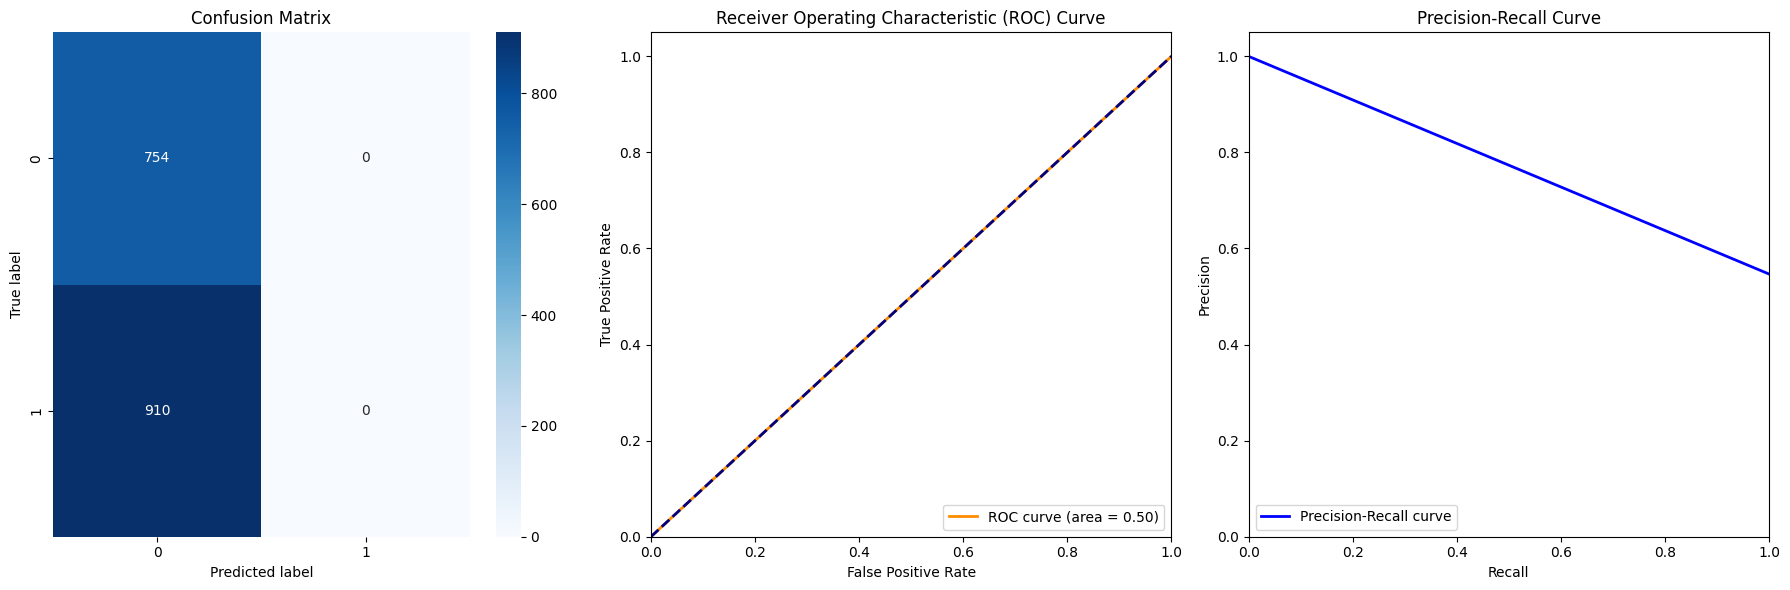

In [ ]:
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn.metrics import classification_report, matthews_corrcoef, roc_curve, auc, precision_recall_curve

def visualize_confusion_matrix(y_pred_argmax, y_true):
    """
    Visualizes the confusion matrix and prints evaluation metrics.

    :param y_pred_argmax: Predicted labels (array with values that are 0 or 1)
    :param y_true: True labels (array with values that are 0 or 1)
    """
    cm = tf.math.confusion_matrix(y_true, y_pred_argmax).numpy()
    con_mat_df = pd.DataFrame(cm)

    print(classification_report(y_true, y_pred_argmax))

    mcc = matthews_corrcoef(y_true, y_pred_argmax)
    print("Matthews Correlation Coefficient:", mcc)

    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_true, y_pred_argmax)
    roc_auc = auc(fpr, tpr)

    # Compute Precision-Recall curve and area the curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred_argmax)

    # Plotting
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Confusion Matrix
    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues, ax=ax1)
    ax1.set_title('Confusion Matrix')
    ax1.set_ylabel('True label')
    ax1.set_xlabel('Predicted label')

    # ROC Curve
    ax2.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax2.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax2.set_xlim([0.0, 1.0])
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.set_title('Receiver Operating Characteristic (ROC) Curve')
    ax2.legend(loc="lower right")

    # Precision-Recall Curve
    ax3.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
    ax3.set_xlim([0.0, 1.0])
    ax3.set_ylim([0.0, 1.05])
    ax3.set_xlabel('Recall')
    ax3.set_ylabel('Precision')
    ax3.set_title('Precision-Recall Curve')
    ax3.legend(loc="lower left")

    plt.tight_layout()
    plt.show()

# Assuming y_pred_argmax and y_true are defined elsewhere in your code
visualize_confusion_matrix(y_pred_argmax, y_true)


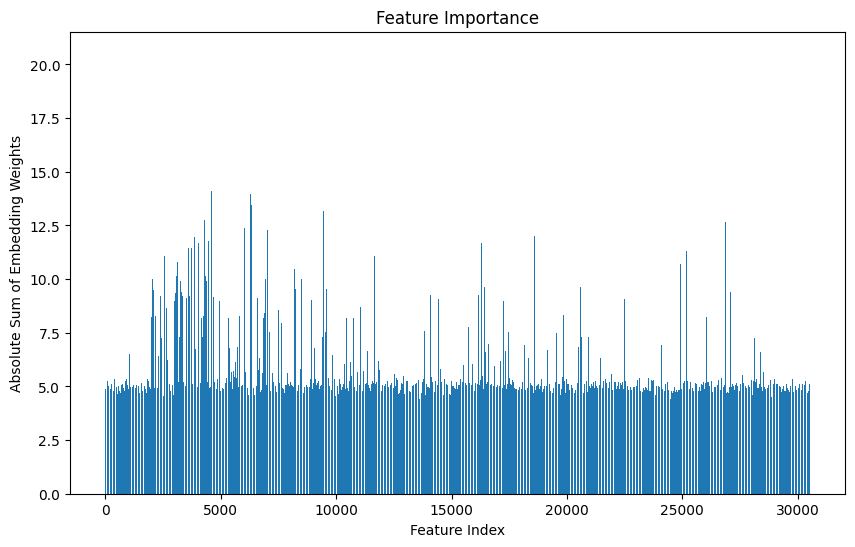

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming model and embedding_weights are defined
embedding_weights = text_model.layers[0].get_weights()[0]

# Calculate the absolute sum of embedding weights for each feature
feature_importance = np.sum(np.abs(embedding_weights), axis=1)

# Plotting feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.xlabel('Feature Index')
plt.ylabel('Absolute Sum of Embedding Weights')
plt.title('Feature Importance')
plt.show()
